# Direct marketing optimisation  
In this notebook, we will create the models needed for prediction, then generate the expected revenue report.

Recap:  
"The general strategy is to calculate the expected revenue, by training 2 models for each product; a classifier and a  
regressor. The classifier provides the probability of sale, and the regressor provides the estimated revenue. In our  
method, we train the regressor by ignoring all the negative class."

The actual details and decisions will be discussed in the section(s).

**Table of contents**
1. [Imports](#Imports)
1. [Baseline](#Baseline)
1. [Model Selection](#Model-Selection)
1. [Results](#Results)

## Imports
[Back to Top](#Direct-marketing-optimisation)

In [1]:
import os
import mlflow

os.chdir("..")
os.path.abspath(".")
mlflow.set_tracking_uri("http://localhost:8080")

In [2]:
import pandas as pd
from loguru import logger

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error

from src.features import suffixes
from src.file_path import preprocessed_data_directory
from src.marketing_targeting_pipeline import full_pipeline, split_and_scale
from src.optuna_training_params import (
    optimise_params_logistic_regression,
    optimise_params_random_forest_classifier,
    optimise_params_random_forest_regressor,
    optimise_params_ridge_regressor,
)

random_seed = 42

/Users/samuelkoh/projects/singlife_technical/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Baseline
[Back to Top](#Direct-marketing-optimisation)

### Preparing the datasets
In this section, we load the 6 preprocessed datasets, perform train test split and store them in a dictionary for  
baseline modeling.

[Back to Top](#Direct-marketing-optimisation)

In [3]:
csv_files_names = {
    suffix: (f"sale_{suffix.lower()}.csv", f"revenue_{suffix.lower()}.csv")
    for suffix in suffixes
}

In [4]:
csv_files = {
    suffix: (
        pd.read_csv(preprocessed_data_directory + sale_file),
        pd.read_csv(preprocessed_data_directory + revenue_file),
    )
    for suffix, (sale_file, revenue_file) in csv_files_names.items()
}

In [5]:
train_test_splits = {
    suffix: (
        split_and_scale(
            data=sale_data,
            target_column=f"Sale_{suffix}",
            test_size=0.2,
            random_state=random_seed,
            stratify=sale_data[f"Sale_{suffix}"],
        ),
        split_and_scale(
            data=revenue_data,
            target_column=f"Revenue_{suffix}",
            test_size=0.2,
            random_state=random_seed,
        ),
    )
    for suffix, (sale_data, revenue_data) in csv_files.items()
}

### Train baseline models

**Logistic Regression (Classification)**

- **Train AUROC (across suffixes):**
    - 'CC': 0.63, 'CL': 0.65, 'MF': 0.61
- **Test AUROC (across suffixes):**
    - 'CC': 0.57, 'CL': 0.66, 'MF': 0.62
    - The model generalizes reasonably well for all suffixes with similar train-test AUROC values. However, the low  
        AUROC scores (close to 0.6–0.66) suggest slight underfitting and that the features might not fully capture  
        relationships with the target variable.
    - **Interpretation**: Features are moderately predictive, but model performance may benefit from feature engineering  
        or trying more complex models. Class imbalance should also be investigated and addressed if present.

---

**Ridge Regression (Regression)**

- **Train MSE (across suffixes):**
    - 'CC': 385.78, 'CL': 37.33, 'MF': 97.98
- **Test MSE (across suffixes):**
    - 'CC': 109.75, 'CL': 128.51, 'MF': 125.43
    - For 'CC', the model shows a large train-test gap, indicating underfitting. For 'CL', the low train errors compared  
        to higher test errors suggest overfitting. 'MF' generalizes reasonably with close train-test errors.
    - **Interpretation**: Ridge Regression performs best for 'MF', but struggles with overfitting on 'CL' and  
        underfitting on 'CC'. Hyperparameter tuning (e.g., adjusting `alpha`) and feature transformations could improve  
        results.

---

**Random Forest Classifier (Classification)**

- **Train AUROC (across suffixes):**
    - 'CC': 1.00, 'CL': 1.00, 'MF': 1.00
- **Test AUROC (across suffixes):**
    - 'CC': 0.58, 'CL': 0.72, 'MF': 0.51
    - The classifier perfectly ranks predictions on the training set but shows a significant drop in test performance  
        across all suffixes, indicating severe overfitting. This is most pronounced for 'MF' with a test AUROC of 0.51.
    - **Interpretation**: Random Forest overfits the training data across all suffixes. Regularization (e.g., increasing  
        `min_samples_leaf`, reducing `max_depth`) or pruning the number of features considered (`max_features`) can  
        mitigate this.

---

**Random Forest Regressor (Regression)**

- **Train MSE (across suffixes):**
    - 'CC': 50.99, 'CL': 5.70, 'MF': 13.63
    
- **Test MSE (across suffixes):**
    - 'CC': 214.57, 'CL': 134.90, 'MF': 125.73
    - The regressor achieves very low train errors but has significantly higher test errors across all suffixes,  
        indicating overfitting. The gap is largest for 'CC' with a test MSE of 214.57.
    - **Interpretation**: Random Forest Regressor significantly overfits across all suffixes. Hyperparameter tuning,  
        such as increasing `min_samples_split` or limiting `max_depth`, could improve test performance.

---

**Overall Recommendations**
1. **Logistic Regression**:
    - Explore feature engineering to enhance predictive power and address potential underfitting.
    - Handle class imbalance using techniques like `class_weight='balanced'` or oversampling.

2. **Ridge Regression**:
    - Fine-tune the `alpha` parameter to balance bias-variance trade-off.
    - Experiment with feature transformations (e.g., polynomial features or interactions) for non-linear relationships.

3. **Random Forest**:
    - For both classification and regression tasks:
        - Address overfitting by tuning hyperparameters such as `max_depth`, `min_samples_leaf`, and `min_samples_split`.
        - Reduce `max_features` to limit the complexity of splits.
    - Evaluate with cross-validation to better estimate generalization performance.


In [6]:
results = {}

for suffix, (
    (X_train_sale, X_test_sale, y_train_sale, y_test_sale),
    (X_train_revenue, X_test_revenue, y_train_revenue, y_test_revenue),
) in train_test_splits.items():

    logistic_model = LogisticRegression(random_state=random_seed, max_iter=1000)
    logistic_model.fit(X_train_sale, y_train_sale)
    y_train_prob = logistic_model.predict_proba(X_train_sale)[:, 1]
    y_test_prob = logistic_model.predict_proba(X_test_sale)[:, 1]
    train_auroc = roc_auc_score(y_train_sale, y_train_prob)
    test_auroc = roc_auc_score(y_test_sale, y_test_prob)

    ridge_model = Ridge(random_state=random_seed)
    ridge_model.fit(X_train_revenue, y_train_revenue)
    y_train_pred = ridge_model.predict(X_train_revenue)
    y_test_pred = ridge_model.predict(X_test_revenue)
    train_mse = mean_squared_error(y_train_revenue, y_train_pred)
    test_mse = mean_squared_error(y_test_revenue, y_test_pred)

    rf_classifier = RandomForestClassifier(random_state=random_seed, n_estimators=100)
    rf_classifier.fit(X_train_sale, y_train_sale)
    y_train_prob_rf = rf_classifier.predict_proba(X_train_sale)[:, 1]
    y_test_prob_rf = rf_classifier.predict_proba(X_test_sale)[:, 1]
    train_auroc_rf = roc_auc_score(y_train_sale, y_train_prob_rf)
    test_auroc_rf = roc_auc_score(y_test_sale, y_test_prob_rf)

    rf_regressor = RandomForestRegressor(random_state=random_seed, n_estimators=100)
    rf_regressor.fit(X_train_revenue, y_train_revenue)
    y_train_pred_rf = rf_regressor.predict(X_train_revenue)
    y_test_pred_rf = rf_regressor.predict(X_test_revenue)
    train_mse_rf = mean_squared_error(y_train_revenue, y_train_pred_rf)
    test_mse_rf = mean_squared_error(y_test_revenue, y_test_pred_rf)

    results[suffix] = {
        "LogisticRegression": {"Train AUROC": train_auroc, "Test AUROC": test_auroc},
        "RidgeRegression": {"Train MSE": train_mse, "Test MSE": test_mse},
        "RandomForestClassifier": {
            "Train AUROC": train_auroc_rf,
            "Test AUROC": test_auroc_rf,
        },
        "RandomForestRegressor": {"Train MSE": train_mse_rf, "Test MSE": test_mse_rf},
    }
    logger.info(f"Results for suffix '{suffix}':")
    logger.info(
        f"  Logistic Regression - Train AUROC: {train_auroc:.2f}, Test AUROC: {test_auroc:.2f}"
    )
    logger.info(
        f"  Ridge Regression - Train MSE: {train_mse:.2f}, Test MSE: {test_mse:.2f}"
    )
    logger.info(
        f"  Random Forest Classifier - Train AUROC: {train_auroc_rf:.2f}, Test AUROC: {test_auroc_rf:.2f}"
    )
    logger.info(
        f"  Random Forest Regressor - Train MSE: {train_mse_rf:.2f}, Test MSE: {test_mse_rf:.2f}"
    )

2025-01-01 18:59:30.040 | INFO     | __main__:<module>:45 - Results for suffix 'CC':
2025-01-01 18:59:30.040 | INFO     | __main__:<module>:46 -   Logistic Regression - Train AUROC: 0.63, Test AUROC: 0.57
2025-01-01 18:59:30.041 | INFO     | __main__:<module>:49 -   Ridge Regression - Train MSE: 385.78, Test MSE: 109.75
2025-01-01 18:59:30.041 | INFO     | __main__:<module>:52 -   Random Forest Classifier - Train AUROC: 1.00, Test AUROC: 0.58
2025-01-01 18:59:30.041 | INFO     | __main__:<module>:55 -   Random Forest Regressor - Train MSE: 50.99, Test MSE: 214.57
2025-01-01 18:59:30.421 | INFO     | __main__:<module>:45 - Results for suffix 'CL':
2025-01-01 18:59:30.422 | INFO     | __main__:<module>:46 -   Logistic Regression - Train AUROC: 0.65, Test AUROC: 0.66
2025-01-01 18:59:30.422 | INFO     | __main__:<module>:49 -   Ridge Regression - Train MSE: 37.33, Test MSE: 128.51
2025-01-01 18:59:30.422 | INFO     | __main__:<module>:52 -   Random Forest Classifier - Train AUROC: 1.00, T

# Model Selection

1. **General Strategy**
The strategy involves estimating the **expected revenue** for each product by leveraging a combination of two models:
    1. **Classifier**: Predicts the **probability of a sale** for a product.
    2. **Regressor**: Estimates the **revenue generated** from the sale.

    **Key Detail**
    In this approach, the regressor is trained **only on the positive class** (i.e., ignoring instances where no sale  
    occurs). This ensures the model focuses solely on predicting revenue for successful transactions, aligning its  
    learning objective with the positive outcomes.

1. **Why This General Strategy?**
This strategy is chosen because the information obtained from training both models together transforms predicted values  
into **expected revenue**. However, due to class imbalance, this approach could underestimate revenue. By focusing on  
training the regressor to predict revenue directly from the positive class, we aim to achieve better accuracy in revenue  
estimation.

1. **Handling Class Imbalance**
Addressing class imbalance is critical for robust model performance. Typical methods include:
    1. **SMOTE (Oversampling)**: Generates synthetic samples of the minority class.
    2. **Downsampling**: Reduces the size of the majority class.
    3. **Class Weights**: Adjusts the loss function to account for class imbalance.

    **Chosen Approach**  
    We opt to use **class weights** exclusively for the following reasons:
        1. **Dataset Size**: The dataset is small, making downsampling impractical.
        2. **Avoiding Noise Amplification**:
            - SMOTE can propagate noise by generating synthetic samples between distant points (potentially outliers).
            - In higher dimensions, the risk of creating irrelevant or noisy data increases.
        3. **Simplicity and Robustness**: Class weights provide a straightforward and effective means of handling  
            imbalance without introducing synthetic data.

1. **Metrics**
    1. Classification
    We use **ROC-AUC** as the primary metric for the classifier. This metric evaluates the ability to distinguish  
    between positive and negative classes, which is crucial for generating a well-calibrated probability distribution.
    1. Regression
    We employ **Mean Squared Error (MSE)** to evaluate the regressor, as it is a standard metric for assessing the  
    accuracy of continuous predictions, such as revenue estimates.

1. **Feature Selection**
Refer to the other notebook for detailed feature selection.

1. **Hyperparameter Optimization**
Hyperparameter tuning was performed for each model individually using Optuna.

1. **Handling Multicollinearity**
We addressed multicollinearity by computing various correlation measures and selecting features to minimize high  
correlations.

1. **Model Calibration**
Due to time constraints, calibration methods such as isotonic regression or Platt scaling were not implemented but  
remain a potential improvement.

1. **Regularization**
Tree models, being prone to overfitting, were regularized using parameters such as `max_depth`, `min_samples_split`,  
and `min_samples_leaf`.

1. **Model Choice**
We primarily used Random Forests, as they consistently provided good results. The pipeline supports multiple models,  
each capable of accepting its own set of hyperparameters for tuning.

[Back to Top](#Model-Selection)

2025-01-01 18:59:31.103 | INFO     | src.marketing_targeting_pipeline:train_model_group:141 - Training Sale models for CC...
2025-01-01 18:59:31.105 | INFO     | src.marketing_targeting_pipeline:train_model_group:157 - Running nested CV for LogisticRegression on Sale_CC...
2025-01-01 18:59:31.105 | INFO     | src.model_training:nested_cv_optuna:57 - Starting nested CV with Optuna for dataset: Sale_CC
[I 2025-01-01 18:59:31,251] A new study created in memory with name: no-name-3bfde583-c365-47d7-acd0-6ef805d52674
[I 2025-01-01 18:59:31,262] Trial 0 finished with value: 0.5973989040060469 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 2.915443189153755, 'max_iter': 641}. Best is trial 0 with value: 0.5973989040060469.
[I 2025-01-01 18:59:31,262] Trial 1 pruned. 
[I 2025-01-01 18:59:31,270] Trial 2 finished with value: 0.5971239606953892 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.029204338471814112, 'max_iter': 510}. Best is trial 0 with value: 0.59739890400604

🏃 View run fold_1 at: http://localhost:8080/#/experiments/0/runs/497e9bd8cdc342978c9cba921aec35b0
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 18:59:32,550] Trial 21 finished with value: 0.587037037037037 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.00104559948561911, 'max_iter': 100}. Best is trial 11 with value: 0.5871305744520029.
[I 2025-01-01 18:59:32,562] Trial 22 finished with value: 0.582842970521542 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.0043409983745338636, 'max_iter': 249}. Best is trial 11 with value: 0.5871305744520029.
[I 2025-01-01 18:59:32,573] Trial 23 finished with value: 0.5839314058956916 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.003138687244595604, 'max_iter': 114}. Best is trial 11 with value: 0.5871305744520029.
[I 2025-01-01 18:59:32,583] Trial 24 finished with value: 0.5828892668178383 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.00436882839983924, 'max_iter': 266}. Best is trial 11 with value: 0.5871305744520029.
[I 2025-01-01 18:59:32,593] Trial 25 finished with value: 0.5868972033257748 and parameters: {'penalty': 'l

🏃 View run fold_2 at: http://localhost:8080/#/experiments/0/runs/120d03e033284d958dd1b2f16c8a371c
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 18:59:33,189] Trial 16 finished with value: 0.5837273242630386 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.007200264482199327, 'max_iter': 488}. Best is trial 16 with value: 0.5837273242630386.
[I 2025-01-01 18:59:33,200] Trial 17 finished with value: 0.5796201814058957 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.041683829718188466, 'max_iter': 505}. Best is trial 16 with value: 0.5837273242630386.
[I 2025-01-01 18:59:33,211] Trial 18 finished with value: 0.5833569538926683 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.008775851890244908, 'max_iter': 671}. Best is trial 16 with value: 0.5837273242630386.
[I 2025-01-01 18:59:33,212] Trial 19 pruned. 
[I 2025-01-01 18:59:33,223] Trial 20 finished with value: 0.580561224489796 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.06146626241448586, 'max_iter': 461}. Best is trial 16 with value: 0.5837273242630386.
[I 2025-01-01 18:59:33,233] Trial 21 finished with value: 0.

🏃 View run fold_3 at: http://localhost:8080/#/experiments/0/runs/4a958963c44e400b896da4a0cb605f15
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 18:59:33,830] Trial 16 finished with value: 0.6079572940287226 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 9.853395337131575, 'max_iter': 463}. Best is trial 12 with value: 0.6186422902494332.
[I 2025-01-01 18:59:33,839] Trial 17 finished with value: 0.6101143235071808 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.010783068241069607, 'max_iter': 861}. Best is trial 12 with value: 0.6186422902494332.
[I 2025-01-01 18:59:33,849] Trial 18 finished with value: 0.6106755479969765 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.0047012519924457, 'max_iter': 106}. Best is trial 12 with value: 0.6186422902494332.
[I 2025-01-01 18:59:33,858] Trial 19 finished with value: 0.5 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.019505081659404948, 'max_iter': 894}. Best is trial 12 with value: 0.6186422902494332.
[I 2025-01-01 18:59:33,859] Trial 20 pruned. 
[I 2025-01-01 18:59:33,868] Trial 21 finished with value: 0.61

🏃 View run fold_4 at: http://localhost:8080/#/experiments/0/runs/742e9143581943098a18625f725a816a
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 18:59:34,460] Trial 25 finished with value: 0.6066855631141346 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.007772779504198083, 'max_iter': 398}. Best is trial 22 with value: 0.6110109599395314.
[I 2025-01-01 18:59:34,469] Trial 26 finished with value: 0.6105234315948601 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.08649741805106576, 'max_iter': 528}. Best is trial 22 with value: 0.6110109599395314.
[I 2025-01-01 18:59:34,480] Trial 27 finished with value: 0.6146296296296296 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.15092705516296664, 'max_iter': 269}. Best is trial 27 with value: 0.6146296296296296.
/Users/samuelkoh/projects/singlife_technical/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/samuelkoh/projects/singlife_technical/.venv/lib/python3.12/site-packages/sklearn/linear_model/_s

🏃 View run fold_5 at: http://localhost:8080/#/experiments/0/runs/30da30259b3a4b849d788b36fd0aac54
🧪 View experiment at: http://localhost:8080/#/experiments/0
🏃 View run LogisticRegression_Sale_CC at: http://localhost:8080/#/experiments/0/runs/56bc2a5252b744a3952e3d7d0a5257d9
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 18:59:36,240] Trial 0 finished with value: 0.563078231292517 and parameters: {'n_estimators': 422, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.563078231292517.
[I 2025-01-01 18:59:36,441] Trial 1 finished with value: 0.563505291005291 and parameters: {'n_estimators': 91, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 1 with value: 0.563505291005291.
[I 2025-01-01 18:59:36,995] Trial 2 finished with value: 0.57171768707483 and parameters: {'n_estimators': 252, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 2 with value: 0.57171768707483.
[I 2025-01-01 18:59:37,806] Trial 3 finished with value: 0.553642290249433 and parameters: {'n_estimators': 406, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.57171768707483.
[I 2025

🏃 View run fold_1 at: http://localhost:8080/#/experiments/0/runs/8fb43823669f4a4bb57eaeb53eb65639
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 18:59:56,437] Trial 0 finished with value: 0.5861668556311413 and parameters: {'n_estimators': 313, 'max_depth': 29, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5861668556311413.
[I 2025-01-01 18:59:57,323] Trial 1 finished with value: 0.598474111866969 and parameters: {'n_estimators': 484, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.598474111866969.
[I 2025-01-01 18:59:58,292] Trial 2 finished with value: 0.5969057067271354 and parameters: {'n_estimators': 497, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 1 with value: 0.598474111866969.
[I 2025-01-01 18:59:59,095] Trial 3 finished with value: 0.586557067271353 and parameters: {'n_estimators': 363, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.598474111866969.
[I

🏃 View run fold_2 at: http://localhost:8080/#/experiments/0/runs/551c5dd7db8a481daf2badcbed679ae0
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:00:32,809] Trial 0 finished with value: 0.5543565759637188 and parameters: {'n_estimators': 429, 'max_depth': 26, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5543565759637188.
[I 2025-01-01 19:00:33,747] Trial 1 finished with value: 0.5517734315948601 and parameters: {'n_estimators': 439, 'max_depth': 25, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.5543565759637188.
[I 2025-01-01 19:00:34,799] Trial 2 finished with value: 0.5530753968253969 and parameters: {'n_estimators': 476, 'max_depth': 26, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.5543565759637188.
[I 2025-01-01 19:00:35,526] Trial 3 finished with value: 0.5562641723356009 and parameters: {'n_estimators': 323, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.55626417233560

🏃 View run fold_3 at: http://localhost:8080/#/experiments/0/runs/c833dc39705f44e4b3fea90b5e086500
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:00:52,501] Trial 0 finished with value: 0.5603656462585034 and parameters: {'n_estimators': 198, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5603656462585034.
[I 2025-01-01 19:00:52,758] Trial 1 finished with value: 0.5778845427059713 and parameters: {'n_estimators': 118, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.5778845427059713.
[I 2025-01-01 19:00:53,394] Trial 2 finished with value: 0.5546315192743764 and parameters: {'n_estimators': 263, 'max_depth': 21, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.5778845427059713.
[I 2025-01-01 19:00:53,784] Trial 3 finished with value: 0.5714606953892668 and parameters: {'n_estimators': 175, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5778845427059713

🏃 View run fold_4 at: http://localhost:8080/#/experiments/0/runs/7221382c81c2454f988eeb267869a76f
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:01:28,071] Trial 0 finished with value: 0.6043915343915344 and parameters: {'n_estimators': 197, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.6043915343915344.
[I 2025-01-01 19:01:28,615] Trial 1 finished with value: 0.603483560090703 and parameters: {'n_estimators': 274, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6043915343915344.
[I 2025-01-01 19:01:28,847] Trial 2 finished with value: 0.6106339758125472 and parameters: {'n_estimators': 107, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.6106339758125472.
[I 2025-01-01 19:01:29,962] Trial 3 finished with value: 0.6052362055933486 and parameters: {'n_estimators': 494, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 2 with value: 0.6106339758125472

🏃 View run fold_5 at: http://localhost:8080/#/experiments/0/runs/237cddf305174c328121535af642cfd7
🧪 View experiment at: http://localhost:8080/#/experiments/0
🏃 View run RandomForestClassifier_Sale_CC at: http://localhost:8080/#/experiments/0/runs/1b491e7a93924d3b9534102c6c4d97f1
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:01:48,615] Trial 5 finished with value: 927.8778463832333 and parameters: {'alpha': 0.3222264378409148, 'solver': 'sag'}. Best is trial 4 with value: 841.4508686835123.
[W 2025-01-01 19:01:48,622] Trial 6 failed with parameters: {'alpha': 6.599277195883643, 'solver': 'lbfgs'} because of the following error: ValueError('\nAll the 3 fits failed.\nIt is very likely that your model is misconfigured.\nYou can try to debug the error by setting error_score=\'raise\'.\n\nBelow are more details about the failures:\n--------------------------------------------------------------------------------\n3 fits failed with the following error:\nTraceback (most recent call last):\n  File "/Users/samuelkoh/projects/singlife_technical/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score\n    estimator.fit(X_train, y_train, **fit_params)\n  File "/Users/samuelkoh/projects/singlife_technical/.venv/lib/python3.12/site-packages/sklearn/base.py

🏃 View run fold_1 at: http://localhost:8080/#/experiments/0/runs/4137bf0864ff458aab97184d15a44b0c
🧪 View experiment at: http://localhost:8080/#/experiments/0
🏃 View run Ridge_Revenue_CC at: http://localhost:8080/#/experiments/0/runs/2c2d7d1bddcc45caa6c8c7e8a97b7978
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:01:49,163] Trial 0 finished with value: 788.0417146584214 and parameters: {'n_estimators': 258, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 788.0417146584214.
[I 2025-01-01 19:01:49,516] Trial 1 finished with value: 762.0838744030817 and parameters: {'n_estimators': 214, 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 762.0838744030817.
[I 2025-01-01 19:01:49,941] Trial 2 finished with value: 758.181433648782 and parameters: {'n_estimators': 270, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 2 with value: 758.181433648782.
[I 2025-01-01 19:01:50,351] Trial 3 finished with value: 755.647002327766 and parameters: {'n_estimators': 245, 'max_depth': 23, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 3 with value: 755.647002327766.
[I 2025-01

🏃 View run fold_1 at: http://localhost:8080/#/experiments/0/runs/3fc02d2a16f248578785edb07eeebc9f
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:02:04,773] Trial 0 finished with value: 1862.1769609684331 and parameters: {'n_estimators': 167, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 1862.1769609684331.
[I 2025-01-01 19:02:05,204] Trial 1 finished with value: 1844.6450047456874 and parameters: {'n_estimators': 284, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 1844.6450047456874.
[I 2025-01-01 19:02:05,496] Trial 2 finished with value: 1849.5503128835092 and parameters: {'n_estimators': 190, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 1 with value: 1844.6450047456874.
[I 2025-01-01 19:02:05,871] Trial 3 finished with value: 1889.436567674474 and parameters: {'n_estimators': 172, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 1844.6450047456874

🏃 View run fold_2 at: http://localhost:8080/#/experiments/0/runs/6ccbb0e8948345b69b2146e24f4891c7
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:02:21,573] Trial 0 finished with value: 1566.787135667744 and parameters: {'n_estimators': 144, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 1566.787135667744.
[I 2025-01-01 19:02:21,798] Trial 1 finished with value: 1562.1050531996898 and parameters: {'n_estimators': 135, 'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 1562.1050531996898.
[I 2025-01-01 19:02:22,214] Trial 2 finished with value: 1528.8636984074935 and parameters: {'n_estimators': 271, 'max_depth': 26, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 2 with value: 1528.8636984074935.
[I 2025-01-01 19:02:22,631] Trial 3 finished with value: 1557.7367784912842 and parameters: {'n_estimators': 280, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 1528.8636984074935.


🏃 View run fold_3 at: http://localhost:8080/#/experiments/0/runs/c165ba8590a9482cba20d544bebe1f52
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:02:40,294] Trial 0 finished with value: 1858.167855731097 and parameters: {'n_estimators': 215, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 1858.167855731097.
[I 2025-01-01 19:02:40,589] Trial 1 finished with value: 1847.063180954148 and parameters: {'n_estimators': 102, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 1 with value: 1847.063180954148.
[I 2025-01-01 19:02:40,962] Trial 2 finished with value: 1882.0092353154598 and parameters: {'n_estimators': 233, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 1 with value: 1847.063180954148.
[I 2025-01-01 19:02:41,137] Trial 3 finished with value: 1948.5596356306849 and parameters: {'n_estimators': 109, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 1847.063180954148.
[I 

🏃 View run fold_4 at: http://localhost:8080/#/experiments/0/runs/cdeba3d6310749b88b94a46896b4db58
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:02:57,687] Trial 0 finished with value: 1582.4127764944076 and parameters: {'n_estimators': 189, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 1582.4127764944076.
[I 2025-01-01 19:02:58,046] Trial 1 finished with value: 1613.7573309899838 and parameters: {'n_estimators': 232, 'max_depth': 22, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 1582.4127764944076.
[I 2025-01-01 19:02:58,495] Trial 2 finished with value: 1594.4059002136064 and parameters: {'n_estimators': 298, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 1582.4127764944076.
[I 2025-01-01 19:02:58,820] Trial 3 finished with value: 1594.4682432388345 and parameters: {'n_estimators': 214, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 1582.412776494407

🏃 View run fold_5 at: http://localhost:8080/#/experiments/0/runs/6064b0ee3f7e40fba6789ab3796461c8
🧪 View experiment at: http://localhost:8080/#/experiments/0
🏃 View run RandomForestRegressor_Revenue_CC at: http://localhost:8080/#/experiments/0/runs/a5b407964ae74b4e9820cc3f770ded31
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:03:13,457] A new study created in memory with name: no-name-c560c0b9-e27b-40df-85c5-cc75b2407aa3
[I 2025-01-01 19:03:13,466] Trial 0 finished with value: 0.5 and parameters: {'penalty': 'elasticnet', 'solver': 'saga', 'l1_ratio': 0.23877714576830233, 'C': 0.0027662820108131335, 'max_iter': 419}. Best is trial 0 with value: 0.5.
[I 2025-01-01 19:03:13,474] Trial 1 finished with value: 0.5593420739912242 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.034459310919273366, 'max_iter': 712}. Best is trial 1 with value: 0.5593420739912242.
[I 2025-01-01 19:03:13,488] Trial 2 finished with value: 0.5552871361233367 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.07406380926311093, 'max_iter': 652}. Best is trial 1 with value: 0.5593420739912242.
[I 2025-01-01 19:03:13,497] Trial 3 finished with value: 0.5689176546334299 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.008369109437186469, 'max_iter': 259}. Best is trial 3 with value: 0.568

🏃 View run fold_1 at: http://localhost:8080/#/experiments/0/runs/45008958dc35460fa933fb4baad4c551
🧪 View experiment at: http://localhost:8080/#/experiments/0


/Users/samuelkoh/projects/singlife_technical/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-01-01 19:03:14,312] Trial 21 finished with value: 0.6507877931295719 and parameters: {'penalty': 'elasticnet', 'solver': 'saga', 'l1_ratio': 0.01183311897886051, 'C': 0.6055833483490475, 'max_iter': 290}. Best is trial 21 with value: 0.6507877931295719.
[I 2025-01-01 19:03:14,336] Trial 22 finished with value: 0.6516090596999783 and parameters: {'penalty': 'elasticnet', 'solver': 'saga', 'l1_ratio': 0.011231022570338478, 'C': 0.16692151343350667, 'max_iter': 322}. Best is trial 22 with value: 0.6516090596999783.
/Users/samuelkoh/projects/singlife_technical/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-01-01 19:03:14,368] Trial 23 finishe

🏃 View run fold_2 at: http://localhost:8080/#/experiments/0/runs/00ac5f4d7d0847a8abcad8ee704f04e9
🧪 View experiment at: http://localhost:8080/#/experiments/0


/Users/samuelkoh/projects/singlife_technical/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-01-01 19:03:15,126] Trial 12 finished with value: 0.6314967349791664 and parameters: {'penalty': 'elasticnet', 'solver': 'saga', 'l1_ratio': 0.03876340293323594, 'C': 4.96821326724577, 'max_iter': 429}. Best is trial 12 with value: 0.6314967349791664.
[I 2025-01-01 19:03:15,157] Trial 13 finished with value: 0.6312296846756236 and parameters: {'penalty': 'elasticnet', 'solver': 'saga', 'l1_ratio': 0.0023423894116658406, 'C': 0.5769953625728337, 'max_iter': 383}. Best is trial 12 with value: 0.6314967349791664.
/Users/samuelkoh/projects/singlife_technical/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-01-01 19:03:15,193] Trial 14 finished 

🏃 View run fold_3 at: http://localhost:8080/#/experiments/0/runs/34c5ae8038434dbeb69f074743d6cb88
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:03:16,019] Trial 17 finished with value: 0.620009183693888 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.015627227624785005, 'max_iter': 450}. Best is trial 14 with value: 0.6215271261251868.
[I 2025-01-01 19:03:16,032] Trial 18 finished with value: 0.6209706279771966 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.023348801946211657, 'max_iter': 146}. Best is trial 14 with value: 0.6215271261251868.
[I 2025-01-01 19:03:16,044] Trial 19 finished with value: 0.5 and parameters: {'penalty': 'elasticnet', 'solver': 'saga', 'l1_ratio': 0.7056392492985978, 'C': 0.002504091450648188, 'max_iter': 515}. Best is trial 14 with value: 0.6215271261251868.
[I 2025-01-01 19:03:16,054] Trial 20 finished with value: 0.6217380772588781 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.069181124792872, 'max_iter': 113}. Best is trial 20 with value: 0.6217380772588781.
[I 2025-01-01 19:03:16,064] Trial 21 finished with value: 0.6215186305062231 

🏃 View run fold_4 at: http://localhost:8080/#/experiments/0/runs/6226347cbaee48f2aff56a49e8a12eaf
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:03:16,654] Trial 20 finished with value: 0.6116398405210833 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.0030036810006219238, 'max_iter': 663}. Best is trial 19 with value: 0.6194055734770988.
[I 2025-01-01 19:03:16,664] Trial 21 finished with value: 0.6192761030525601 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.04021933026650641, 'max_iter': 334}. Best is trial 19 with value: 0.6194055734770988.
[I 2025-01-01 19:03:16,675] Trial 22 finished with value: 0.6184375643973183 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.23594080342902884, 'max_iter': 443}. Best is trial 19 with value: 0.6194055734770988.
[I 2025-01-01 19:03:16,686] Trial 23 finished with value: 0.6192258314560474 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.03177086717228042, 'max_iter': 248}. Best is trial 19 with value: 0.6194055734770988.
[I 2025-01-01 19:03:16,696] Trial 24 finished with value: 0.6191428763006284 and parameters: {'penalty': 'l

🏃 View run fold_5 at: http://localhost:8080/#/experiments/0/runs/3c5cba30b9cc416186b29db8ba88ff3a
🧪 View experiment at: http://localhost:8080/#/experiments/0
🏃 View run LogisticRegression_Sale_CL at: http://localhost:8080/#/experiments/0/runs/95039787a57b49218f7484a6940c14f7
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:03:18,026] Trial 0 finished with value: 0.572709614477939 and parameters: {'n_estimators': 402, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.572709614477939.
[I 2025-01-01 19:03:18,795] Trial 1 finished with value: 0.5624941943678259 and parameters: {'n_estimators': 351, 'max_depth': 25, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.572709614477939.
[I 2025-01-01 19:03:19,036] Trial 2 finished with value: 0.5419043245860053 and parameters: {'n_estimators': 104, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.572709614477939.
[I 2025-01-01 19:03:19,927] Trial 3 finished with value: 0.5557250115586057 and parameters: {'n_estimators': 363, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.572709614477939.
[

🏃 View run fold_1 at: http://localhost:8080/#/experiments/0/runs/438b0ae242ca42ceaadc7a1cbdd8fb9f
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:03:37,791] Trial 0 finished with value: 0.6188865683913124 and parameters: {'n_estimators': 293, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.6188865683913124.
[I 2025-01-01 19:03:38,021] Trial 1 finished with value: 0.6045907937681475 and parameters: {'n_estimators': 104, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.6188865683913124.
[I 2025-01-01 19:03:38,235] Trial 2 finished with value: 0.6137915491059062 and parameters: {'n_estimators': 98, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.6188865683913124.
[I 2025-01-01 19:03:38,808] Trial 3 finished with value: 0.6075892557802681 and parameters: {'n_estimators': 298, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.6188865683913124.

🏃 View run fold_2 at: http://localhost:8080/#/experiments/0/runs/21d71e4061a945b28efe05ddf624c438
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:04:06,680] Trial 0 finished with value: 0.6159692360297094 and parameters: {'n_estimators': 373, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.6159692360297094.
[I 2025-01-01 19:04:07,379] Trial 1 finished with value: 0.6053222946456186 and parameters: {'n_estimators': 310, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6159692360297094.
[I 2025-01-01 19:04:07,812] Trial 2 finished with value: 0.6170799855504266 and parameters: {'n_estimators': 195, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.6170799855504266.
[I 2025-01-01 19:04:08,703] Trial 3 finished with value: 0.6153012416592856 and parameters: {'n_estimators': 410, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.617079985550426

🏃 View run fold_3 at: http://localhost:8080/#/experiments/0/runs/f5050aa95b0a47228c311d91ec84beb8
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:04:32,389] Trial 0 finished with value: 0.5578204805501229 and parameters: {'n_estimators': 369, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5578204805501229.
[I 2025-01-01 19:04:33,526] Trial 1 finished with value: 0.5580619035733205 and parameters: {'n_estimators': 472, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 1 with value: 0.5580619035733205.
[I 2025-01-01 19:04:34,150] Trial 2 finished with value: 0.5585211584794528 and parameters: {'n_estimators': 282, 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5585211584794528.
[I 2025-01-01 19:04:35,145] Trial 3 finished with value: 0.5551793611224327 and parameters: {'n_estimators': 469, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5585211584794528

🏃 View run fold_4 at: http://localhost:8080/#/experiments/0/runs/3104fa4eaf5543169e6a896b094ebc2e
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:04:54,435] Trial 0 finished with value: 0.5803659224574667 and parameters: {'n_estimators': 343, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5803659224574667.
[I 2025-01-01 19:04:55,388] Trial 1 finished with value: 0.58429777916797 and parameters: {'n_estimators': 498, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.58429777916797.
[I 2025-01-01 19:04:55,618] Trial 2 finished with value: 0.5757398121906515 and parameters: {'n_estimators': 104, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.58429777916797.
[I 2025-01-01 19:04:56,734] Trial 3 finished with value: 0.5751710972021679 and parameters: {'n_estimators': 499, 'max_depth': 25, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.58429777916797.
[I 202

🏃 View run fold_5 at: http://localhost:8080/#/experiments/0/runs/73d177fae26d45589a43864287a886fa
🧪 View experiment at: http://localhost:8080/#/experiments/0
🏃 View run RandomForestClassifier_Sale_CL at: http://localhost:8080/#/experiments/0/runs/e298d74621534633937db24a812aa31e
🧪 View experiment at: http://localhost:8080/#/experiments/0
🏃 View run fold_1 at: http://localhost:8080/#/experiments/0/runs/5eae17deec0d4cc7810c2bd03fffb1b3
🧪 View experiment at: http://localhost:8080/#/experiments/0
🏃 View run Ridge_Revenue_CL at: http://localhost:8080/#/experiments/0/runs/ee71384682384350914ca242913c6a21
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:05:20,943] Trial 0 finished with value: 137.43125540076045 and parameters: {'n_estimators': 248, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 137.43125540076045.
[I 2025-01-01 19:05:21,161] Trial 1 finished with value: 134.482962276433 and parameters: {'n_estimators': 137, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 134.482962276433.
[I 2025-01-01 19:05:21,325] Trial 2 finished with value: 134.5957678427598 and parameters: {'n_estimators': 104, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 134.482962276433.
[I 2025-01-01 19:05:21,602] Trial 3 finished with value: 135.16263366129087 and parameters: {'n_estimators': 176, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 134.482962276433.
[I 2025

🏃 View run fold_1 at: http://localhost:8080/#/experiments/0/runs/4c575b7f12d44397b13c7a228e913f7f
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:05:33,971] Trial 0 finished with value: 141.3409729415869 and parameters: {'n_estimators': 231, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 141.3409729415869.
[I 2025-01-01 19:05:34,181] Trial 1 finished with value: 140.22171137004753 and parameters: {'n_estimators': 133, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 1 with value: 140.22171137004753.
[I 2025-01-01 19:05:34,603] Trial 2 finished with value: 143.54907836132273 and parameters: {'n_estimators': 268, 'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 140.22171137004753.
[I 2025-01-01 19:05:34,935] Trial 3 finished with value: 141.1202732095184 and parameters: {'n_estimators': 213, 'max_depth': 22, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 140.22171137004753.
[

🏃 View run fold_2 at: http://localhost:8080/#/experiments/0/runs/82b99a9726c1407b9d3e901b204d343c
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:05:47,349] Trial 1 finished with value: 144.72659876216463 and parameters: {'n_estimators': 196, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 144.72659876216463.
[I 2025-01-01 19:05:47,702] Trial 2 finished with value: 147.88006625902946 and parameters: {'n_estimators': 221, 'max_depth': 21, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 144.72659876216463.
[I 2025-01-01 19:05:47,884] Trial 3 finished with value: 143.6039653389147 and parameters: {'n_estimators': 115, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 3 with value: 143.6039653389147.
[I 2025-01-01 19:05:48,230] Trial 4 finished with value: 147.96641142746165 and parameters: {'n_estimators': 203, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 3 with value: 143.6039653389147.


🏃 View run fold_3 at: http://localhost:8080/#/experiments/0/runs/567740fcb046418aa17e966adbc92857
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:06:05,175] Trial 0 finished with value: 47.954306287779644 and parameters: {'n_estimators': 261, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 47.954306287779644.
[I 2025-01-01 19:06:05,517] Trial 1 finished with value: 47.18860184935818 and parameters: {'n_estimators': 199, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 47.18860184935818.
[I 2025-01-01 19:06:05,715] Trial 2 finished with value: 47.17916734119378 and parameters: {'n_estimators': 127, 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 2 with value: 47.17916734119378.
[I 2025-01-01 19:06:05,957] Trial 3 finished with value: 47.29326291387767 and parameters: {'n_estimators': 156, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 2 with value: 47.17916734119378.
[I

🏃 View run fold_4 at: http://localhost:8080/#/experiments/0/runs/dd5fa04031d04fcfa63ae8b36ce74d7c
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:06:22,645] Trial 0 finished with value: 148.0395818253924 and parameters: {'n_estimators': 212, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 148.0395818253924.
[I 2025-01-01 19:06:23,025] Trial 1 finished with value: 152.73757354110637 and parameters: {'n_estimators': 242, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 148.0395818253924.
[I 2025-01-01 19:06:23,484] Trial 2 finished with value: 152.04718890937002 and parameters: {'n_estimators': 290, 'max_depth': 26, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 148.0395818253924.
[I 2025-01-01 19:06:23,806] Trial 3 finished with value: 147.20073999749346 and parameters: {'n_estimators': 209, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 3 with value: 147.20073999749346.
[

🏃 View run fold_5 at: http://localhost:8080/#/experiments/0/runs/48580c1b7313496ba3c16a9926c96341
🧪 View experiment at: http://localhost:8080/#/experiments/0
🏃 View run RandomForestRegressor_Revenue_CL at: http://localhost:8080/#/experiments/0/runs/5c3950ea46e849f2bdbdbd2a076dc411
🧪 View experiment at: http://localhost:8080/#/experiments/0


/Users/samuelkoh/projects/singlife_technical/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/samuelkoh/projects/singlife_technical/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/samuelkoh/projects/singlife_technical/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
[I 2025-01-01 19:06:36,733] Trial 7 finished with value: 0.5654891609051201 and parameters: {'penalty': None, 'solver': 'lbfgs', 'C': 2.3216150601454997, 'max_iter': 524}. Best is trial 4 with value: 0.5654891609051201.
[I 2025-01-01 19:06:36,739] Trial 8 finished with value: 0.5 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.0050064023389829

🏃 View run fold_1 at: http://localhost:8080/#/experiments/0/runs/514d69a029834ab9803d8f60c3d09bfc
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:06:37,677] Trial 13 finished with value: 0.5751268727499627 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.4183885328873221, 'max_iter': 195}. Best is trial 11 with value: 0.5755503504230158.
/Users/samuelkoh/projects/singlife_technical/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/samuelkoh/projects/singlife_technical/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/samuelkoh/projects/singlife_technical/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-01-01 19:06:37,697] Trial 14 finished with value: 0.5747996768370284 and parameters: {'penalty': 'l2', 'solver': 'saga', 

🏃 View run fold_2 at: http://localhost:8080/#/experiments/0/runs/6bfdedcf846340efbcf3a5dd5ae67b94
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:06:38,955] Trial 12 finished with value: 0.5561731420814612 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 8.791062321323702, 'max_iter': 565}. Best is trial 11 with value: 0.5563454278225076.
/Users/samuelkoh/projects/singlife_technical/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/samuelkoh/projects/singlife_technical/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/samuelkoh/projects/singlife_technical/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-01-01 19:06:38,987] Trial 13 finished with value: 0.5559482019583887 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 6

🏃 View run fold_3 at: http://localhost:8080/#/experiments/0/runs/2d9d89450abe42fd9f473a46769ef9bd
🧪 View experiment at: http://localhost:8080/#/experiments/0


/Users/samuelkoh/projects/singlife_technical/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-01-01 19:06:40,544] Trial 11 finished with value: 0.5409005444659095 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 9.33235665074482, 'max_iter': 699}. Best is trial 8 with value: 0.5511257842327452.
/Users/samuelkoh/projects/singlife_technical/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/samuelkoh/projects/singlife_technical/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-01-01 19:06:40,609] Trial 12 finished with value: 0.5392401222621935 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 8.9

🏃 View run fold_4 at: http://localhost:8080/#/experiments/0/runs/9410f1acdcce421891c56f8708c9cc1a
🧪 View experiment at: http://localhost:8080/#/experiments/0


/Users/samuelkoh/projects/singlife_technical/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/samuelkoh/projects/singlife_technical/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/samuelkoh/projects/singlife_technical/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-01-01 19:06:41,300] Trial 16 finished with value: 0.583936493613913 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 1.1811316190117753, 'max_iter': 420}. Best is trial 12 with value: 0.5869589757535428.
/Users/samuelkoh/projects/singlife_technical/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: T

🏃 View run fold_5 at: http://localhost:8080/#/experiments/0/runs/efad5b93d7004fdda9ca60e37ad48ebf
🧪 View experiment at: http://localhost:8080/#/experiments/0
🏃 View run LogisticRegression_Sale_MF at: http://localhost:8080/#/experiments/0/runs/077b0c643096401eb9252796f05e6dd7
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:06:42,869] Trial 0 finished with value: 0.5784646592796 and parameters: {'n_estimators': 310, 'max_depth': 27, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5784646592796.
[I 2025-01-01 19:06:43,601] Trial 1 finished with value: 0.5779390200442832 and parameters: {'n_estimators': 308, 'max_depth': 29, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5784646592796.
[I 2025-01-01 19:06:44,512] Trial 2 finished with value: 0.5796074515938693 and parameters: {'n_estimators': 431, 'max_depth': 28, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 2 with value: 0.5796074515938693.
[I 2025-01-01 19:06:45,238] Trial 3 finished with value: 0.5820175862620683 and parameters: {'n_estimators': 332, 'max_depth': 28, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 3 with value: 0.5820175862620683.
[I 2

🏃 View run fold_1 at: http://localhost:8080/#/experiments/0/runs/9a37ef5651d048cba57eae85d630c827
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:07:02,478] Trial 0 finished with value: 0.5689472760780062 and parameters: {'n_estimators': 285, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5689472760780062.
[I 2025-01-01 19:07:02,623] Trial 1 finished with value: 0.5729311341365669 and parameters: {'n_estimators': 72, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 1 with value: 0.5729311341365669.
[I 2025-01-01 19:07:03,491] Trial 2 finished with value: 0.5775712874184861 and parameters: {'n_estimators': 412, 'max_depth': 29, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 2 with value: 0.5775712874184861.
[I 2025-01-01 19:07:03,820] Trial 3 finished with value: 0.5713217361774238 and parameters: {'n_estimators': 151, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 2 with value: 0.577571287418486

🏃 View run fold_2 at: http://localhost:8080/#/experiments/0/runs/9aa6f67be34a45d39892de8b3093cce5
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:07:38,949] Trial 0 finished with value: 0.5741808465068227 and parameters: {'n_estimators': 212, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.5741808465068227.
[I 2025-01-01 19:07:39,463] Trial 1 finished with value: 0.5925133723096372 and parameters: {'n_estimators': 245, 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 1 with value: 0.5925133723096372.
[I 2025-01-01 19:07:40,039] Trial 2 finished with value: 0.5889429378393723 and parameters: {'n_estimators': 272, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.5925133723096372.
[I 2025-01-01 19:07:40,825] Trial 3 finished with value: 0.5919060377464452 and parameters: {'n_estimators': 371, 'max_depth': 21, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.592513372309

🏃 View run fold_3 at: http://localhost:8080/#/experiments/0/runs/043eabbd18774964ab8ec2d1d158aab3
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:07:58,302] Trial 0 finished with value: 0.5071780699964061 and parameters: {'n_estimators': 215, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.5071780699964061.
[I 2025-01-01 19:07:58,431] Trial 1 finished with value: 0.5053070491101052 and parameters: {'n_estimators': 56, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.5071780699964061.
[I 2025-01-01 19:07:59,017] Trial 2 finished with value: 0.4988657823971916 and parameters: {'n_estimators': 272, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.5071780699964061.
[I 2025-01-01 19:08:00,068] Trial 3 finished with value: 0.5009164199317001 and parameters: {'n_estimators': 484, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5071780699964061

🏃 View run fold_4 at: http://localhost:8080/#/experiments/0/runs/1b6eb2c2ca9f48e98cd8808661858305
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:08:17,317] Trial 0 finished with value: 0.5223020895346872 and parameters: {'n_estimators': 497, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5223020895346872.
[I 2025-01-01 19:08:17,595] Trial 1 finished with value: 0.5216950188087709 and parameters: {'n_estimators': 138, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5223020895346872.
[I 2025-01-01 19:08:18,468] Trial 2 finished with value: 0.5224993078982892 and parameters: {'n_estimators': 415, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 2 with value: 0.5224993078982892.
[I 2025-01-01 19:08:19,444] Trial 3 finished with value: 0.5208069990752503 and parameters: {'n_estimators': 463, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.52249930789828

🏃 View run fold_5 at: http://localhost:8080/#/experiments/0/runs/60b0077aacc342d68a089bb46135cc0a
🧪 View experiment at: http://localhost:8080/#/experiments/0
🏃 View run RandomForestClassifier_Sale_MF at: http://localhost:8080/#/experiments/0/runs/6258c41aeebc4c148dffbed880db2ae8
🧪 View experiment at: http://localhost:8080/#/experiments/0


2025-01-01 19:08:40.123 | INFO     | src.marketing_targeting_pipeline:train_model_group:177 - Error with model Ridge on Revenue_MF: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/samuelkoh/projects/singlife_technical/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samuelkoh/projects/singlife_technical/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/samuelkoh/projects/singlife_technical/.venv/lib/python3.12/site-packages/sklear

🏃 View run fold_1 at: http://localhost:8080/#/experiments/0/runs/e2745739394d4e83921b05c5a0f7049d
🧪 View experiment at: http://localhost:8080/#/experiments/0
🏃 View run Ridge_Revenue_MF at: http://localhost:8080/#/experiments/0/runs/ca5dc808365044a18bdc737ca684a700
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:08:40,621] Trial 0 finished with value: 232.53153415883943 and parameters: {'n_estimators': 299, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 232.53153415883943.
[I 2025-01-01 19:08:41,057] Trial 1 finished with value: 233.64002387107917 and parameters: {'n_estimators': 284, 'max_depth': 29, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 232.53153415883943.
[I 2025-01-01 19:08:41,382] Trial 2 finished with value: 233.4110333720737 and parameters: {'n_estimators': 213, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 232.53153415883943.
[I 2025-01-01 19:08:41,575] Trial 3 finished with value: 241.6208154041973 and parameters: {'n_estimators': 120, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 232.53153415883943.

🏃 View run fold_1 at: http://localhost:8080/#/experiments/0/runs/6b85927c39f04a04b9c2f4d7fe55ea44
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:08:55,636] Trial 0 finished with value: 575.8769196185061 and parameters: {'n_estimators': 208, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 575.8769196185061.
[I 2025-01-01 19:08:55,795] Trial 1 finished with value: 567.3353496177291 and parameters: {'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 567.3353496177291.
[I 2025-01-01 19:08:56,050] Trial 2 finished with value: 580.3665791486538 and parameters: {'n_estimators': 161, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 567.3353496177291.
[I 2025-01-01 19:08:56,271] Trial 3 finished with value: 563.8192864601225 and parameters: {'n_estimators': 145, 'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 3 with value: 563.8192864601225.
[I 2

🏃 View run fold_2 at: http://localhost:8080/#/experiments/0/runs/cc3318840fc94c6ab26e8e324bbb3b90
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:09:10,517] Trial 0 finished with value: 699.257876377139 and parameters: {'n_estimators': 246, 'max_depth': 27, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 699.257876377139.
[I 2025-01-01 19:09:10,770] Trial 1 finished with value: 705.9463030033113 and parameters: {'n_estimators': 167, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 699.257876377139.
[I 2025-01-01 19:09:11,230] Trial 2 finished with value: 740.790470741585 and parameters: {'n_estimators': 290, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 699.257876377139.
[I 2025-01-01 19:09:11,497] Trial 3 finished with value: 716.8658848445798 and parameters: {'n_estimators': 177, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 699.257876377139.
[I 2025-01-

🏃 View run fold_3 at: http://localhost:8080/#/experiments/0/runs/1e4234b7148a48799630d8bd6eb42f09
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:09:26,014] Trial 0 finished with value: 652.6842905257035 and parameters: {'n_estimators': 247, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 652.6842905257035.
[I 2025-01-01 19:09:26,385] Trial 1 finished with value: 660.2282296712198 and parameters: {'n_estimators': 237, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 652.6842905257035.
[I 2025-01-01 19:09:26,743] Trial 2 finished with value: 655.8593497316825 and parameters: {'n_estimators': 234, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 652.6842905257035.
[I 2025-01-01 19:09:26,975] Trial 3 finished with value: 647.4217073552426 and parameters: {'n_estimators': 155, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 3 with value: 647.4217073552426.
[I 2

🏃 View run fold_4 at: http://localhost:8080/#/experiments/0/runs/21669acd71eb4e60a00f4af58402c525
🧪 View experiment at: http://localhost:8080/#/experiments/0


[I 2025-01-01 19:09:38,851] Trial 0 finished with value: 608.7207004993298 and parameters: {'n_estimators': 290, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 608.7207004993298.
[I 2025-01-01 19:09:39,065] Trial 1 finished with value: 615.9028963832558 and parameters: {'n_estimators': 140, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 608.7207004993298.
[I 2025-01-01 19:09:39,390] Trial 2 finished with value: 608.1385401544657 and parameters: {'n_estimators': 217, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 2 with value: 608.1385401544657.
[I 2025-01-01 19:09:39,611] Trial 3 finished with value: 638.3846329833708 and parameters: {'n_estimators': 137, 'max_depth': 21, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 2 with value: 608.1385401544657.
[I 2

🏃 View run fold_5 at: http://localhost:8080/#/experiments/0/runs/047dbbf0c0f7448bb842dcfc10706edc
🧪 View experiment at: http://localhost:8080/#/experiments/0
🏃 View run RandomForestRegressor_Revenue_MF at: http://localhost:8080/#/experiments/0/runs/9b89577fd87b49e1815e13b56d78a270
🧪 View experiment at: http://localhost:8080/#/experiments/0


2025-01-01 19:09:53.963 | INFO     | src.marketing_targeting_pipeline:retrain_best_models:253 - Retraining Sale_CC model completed. AUC: 0.8251812290273829
2025-01-01 19:09:53.965 | INFO     | src.marketing_targeting_pipeline:retrain_best_models:241 - Retraining Revenue_CC model on full dataset...
2025-01-01 19:09:54.092 | INFO     | src.marketing_targeting_pipeline:retrain_best_models:253 - Retraining Revenue_CC model completed. MSE: 929.8533534400544
2025-01-01 19:09:54.094 | INFO     | src.marketing_targeting_pipeline:retrain_best_models:241 - Retraining Sale_CL model on full dataset...
2025-01-01 19:09:54.096 | INFO     | src.marketing_targeting_pipeline:retrain_best_models:253 - Retraining Sale_CL model completed. AUC: 0.6469254032258065
2025-01-01 19:09:54.098 | INFO     | src.marketing_targeting_pipeline:retrain_best_models:241 - Retraining Revenue_CL model on full dataset...
2025-01-01 19:09:54.163 | INFO     | src.marketing_targeting_pipeline:retrain_best_models:253 - Retraini

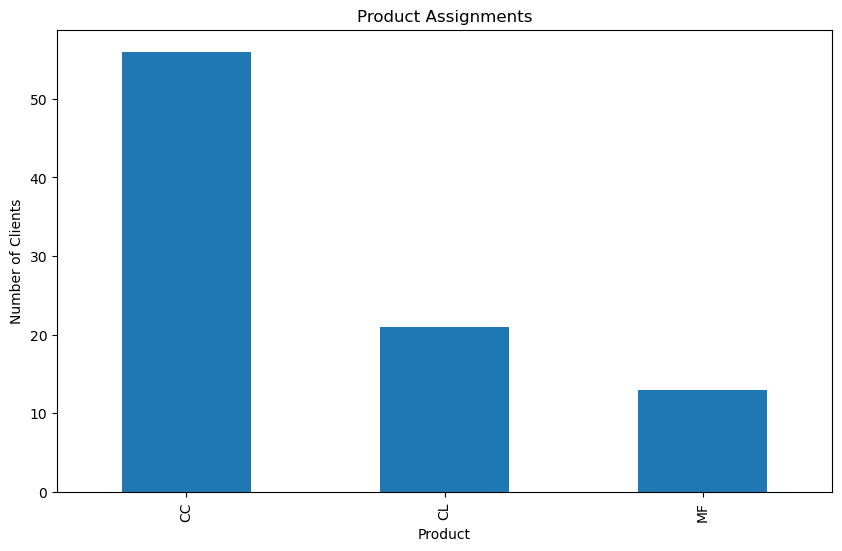

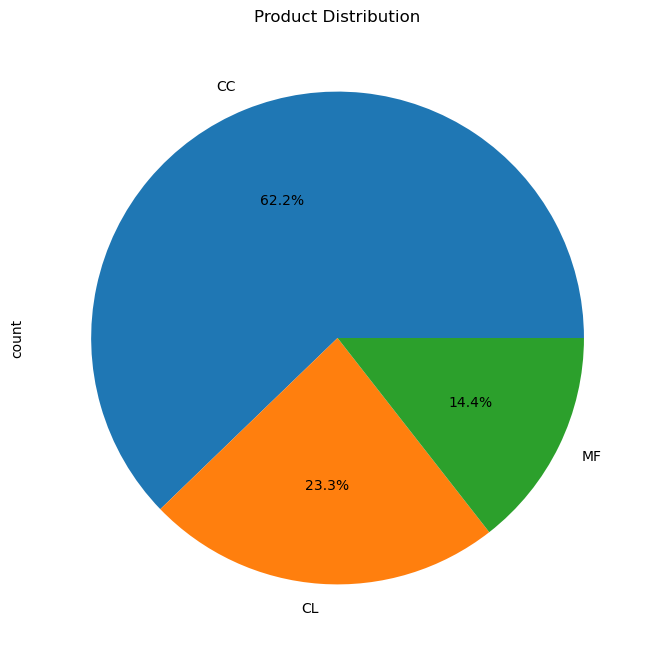

In [7]:
classifiers = [
    (
        LogisticRegression(class_weight="balanced", random_state=random_seed),
        optimise_params_logistic_regression,
    ),
    (
        RandomForestClassifier(class_weight="balanced", random_state=random_seed),
        optimise_params_random_forest_classifier,
    ),
]

regressors = [
    (Ridge(random_state=random_seed), optimise_params_ridge_regressor),
    (
        RandomForestRegressor(random_state=random_seed),
        optimise_params_random_forest_regressor,
    ),
]

results, test_set = full_pipeline(
    "DataScientist_CaseStudy_Dataset.xlsx", classifiers, regressors
)

## Results

Total Expected Revenue: $1050.43
CC: 56 clients
CL: 21 clients
MF: 13 clients
The clients can be found at `targeted_clients.csv`.

Note that while the Expected Revenue might look good, we should also note that the MSE for Revenue_CC model was not
very healhty.

Sale_CC RF AUC: 0.825  
Revenue_CC RF MSE: 929.853  

Sale_CL LR AUC: 0.646  
Revenue_CL RF MSE: 77.976  

Sale_MF RF AUC: 0.981  
Revenue_MF RF MSE: 350.486  

[Back to Top](#Direct-marketing-optimisation)

In [22]:
results_list = [
    "Client",
    "Assigned_Product",
    "Sale_CC_probability",
    "Revenue_CC_prediction",
    "Sale_CL_probability",
    "Revenue_CL_prediction",
    "Sale_MF_probability",
    "Revenue_MF_prediction",
    "Revenue_CC_expected",
    "Revenue_CL_expected",
    "Revenue_MF_expected",
    "Max_Expected_Revenue",
    "Target_Rank",
]
df = test_set[results_list]

In [34]:
df.loc[
    (df.index < 90) & (df["Assigned_Product"] == "CC"),
    [
        "Client",
        "Assigned_Product",
        "Sale_CC_probability",
        "Revenue_CC_prediction",
        "Revenue_CC_expected",
        "Target_Rank",
    ],
]

,Client,Assigned_Product,Sale_CC_probability,Revenue_CC_prediction,Revenue_CC_expected,Target_Rank
0,1460,CC,0.526070,35.057714,18.442814,1
1,382,CC,0.817239,19.701131,16.100536,2
2,1162,CC,0.424262,37.841498,16.054695,3
3,541,CC,0.524481,29.683607,15.568488,4
4,150,CC,0.455303,32.800768,14.934278,5
10,545,CC,0.726702,19.500809,14.171269,11
12,77,CC,0.443185,31.680627,14.040373,13
13,919,CC,0.380574,36.769249,13.993437,14
15,1002,CC,0.483081,28.456332,13.746727,16
17,84,CC,0.512838,26.366653,13.521826,18


In [35]:
df.loc[
    (df.index < 90) & (df["Assigned_Product"] == "CL"),
    [
        "Client",
        "Assigned_Product",
        "Sale_CC_probability",
        "Revenue_CC_prediction",
        "Revenue_CC_expected",
        "Target_Rank",
    ],
]

,Client,Assigned_Product,Sale_CC_probability,Revenue_CC_prediction,Revenue_CC_expected,Target_Rank
5,352,CL,0.673741,8.275075,5.575261,6
6,314,CL,0.713213,6.096467,4.348082,7
7,389,CL,0.781718,7.796287,6.094501,8
8,197,CL,0.723901,7.823470,5.663416,9
9,1200,CL,0.654821,9.324707,6.106018,10
11,16,CL,0.781108,5.037091,3.934510,12
14,243,CL,0.594035,22.706322,13.488352,15
16,19,CL,0.752489,6.318948,4.754937,17
19,1410,CL,0.452495,9.967574,4.510281,20
20,886,CL,0.711951,17.405755,12.392044,21


In [36]:
df.loc[
    (df.index < 90) & (df["Assigned_Product"] == "MF"),
    [
        "Client",
        "Assigned_Product",
        "Sale_CC_probability",
        "Revenue_CC_prediction",
        "Revenue_CC_expected",
        "Target_Rank",
    ],
]

,Client,Assigned_Product,Sale_CC_probability,Revenue_CC_prediction,Revenue_CC_expected,Target_Rank
39,835,MF,0.391101,11.231203,4.392535,40
41,1008,MF,0.334453,7.755516,2.593855,42
43,766,MF,0.361260,6.732345,2.432126,44
48,1077,MF,0.520545,17.452819,9.084983,49
50,368,MF,0.484742,15.940117,7.726839,51
53,233,MF,0.419602,8.239812,3.457443,54
55,959,MF,0.385755,10.602829,4.090092,56
61,313,MF,0.488067,10.313911,5.033878,62
62,929,MF,0.400339,13.075783,5.234745,63
65,265,MF,0.320747,18.181243,5.831586,66


In [23]:
df.iloc[:100].to_csv("targeted_clients.csv", index=False)

In [24]:
# Models used and metrics
results

{'Sale_CC': {'best_model': RandomForestClassifier(class_weight='balanced', max_depth=5,
                         max_features='log2', min_samples_leaf=3,
                         min_samples_split=9, n_estimators=77, random_state=42),
  'best_cv_score': np.float64(0.701951951951952),
  'best_params': {'n_estimators': 77,
   'max_depth': 5,
   'min_samples_split': 9,
   'min_samples_leaf': 3,
   'max_features': 'log2'},
  'train_score': np.float64(0.8472772772772772),
  'test_score': np.float64(0.6179667519181585),
  'retrained_model': RandomForestClassifier(class_weight='balanced', max_depth=5,
                         max_features='log2', min_samples_leaf=3,
                         min_samples_split=9, n_estimators=77, random_state=42),
  'retrained_model_score': np.float64(0.8251812290273829),
  'scaler': StandardScaler()},
 'Revenue_CC': {'best_model': RandomForestRegressor(max_depth=25, max_features='log2', min_samples_leaf=5,
                        min_samples_split=4, n_estimat